In [83]:
# Importing necessary libraries
from datetime import datetime 
import os

import numpy as np

from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

torch.manual_seed(42)

In [85]:
# Defining necessary parameters
BATCH_SIZE = 1
EPOCHS_COUNT = 5

In [64]:
# Defining a class for neutron monitor dataset
class NeutronMonitorDataset(Dataset):
    def __init__(self):
        super().__init__()
        self._wavelets_files, self._labels = NeutronMonitorDataset._get_neutron_monitor_data_files()
        self._length = len(self._wavelets_files)
    
    @staticmethod
    def _get_neutron_monitor_data_files():
        wavelets_files, labels = [], []
        data_dirs_paths = [
            "../input/sopo-neutron-monitor-data/calm_days",
            "../input/sopo-neutron-monitor-data/weak_storms",
            "../input/sopo-neutron-monitor-data/strong_storms"
        ]     
        for index, dir_path in enumerate(data_dirs_paths):
            wavelets_array, labels_array = NeutronMonitorDataset._get_data_files_from_directory(dir_path, index)
            wavelets_files.extend(wavelets_array)
            labels.extend(labels_array)
        return wavelets_files, labels
    
    @staticmethod
    def _get_data_files_from_directory(dir_path, label):
        wavelets_files_array = []
        for _, _, files in os.walk(dir_path):
            for file in files:
                if file != ".gitkeep":
                    file_path = os.path.join(dir_path, file)
                    wavelets_files_array.append(file_path)
        labels_array = [label for _ in range(len(wavelets_files_array))]
        return wavelets_files_array, labels_array
    
    def __len__(self):
        return self._length
    
    def __getitem__(self, index):
        sample_wavelet_file = self._wavelets_files[index]
        sample_wavelet_image = torch.tensor(
            np.loadtxt(sample_wavelet_file, dtype=np.float64, delimiter=','),
            dtype=torch.float32
        )
        sample_label = self._labels[index]
        return sample_wavelet_image, sample_label

In [65]:
# Creating datasets and dataloaders
full_dataset = NeutronMonitorDataset()
train_dataset, valid_dataset = random_split(full_dataset, [85, 10], generator=torch.Generator().manual_seed(42))
print(len(train_dataset), len(test_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)

85 10


In [66]:
# defining modified LeNet model for neutron monitor data
class NeutronMonitorDataLeNet(nn.Module):
    def __init__(self):
        super(NeutronMonitorDataLeNet, self).__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=36),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=36),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(0)
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=23040, out_features=120),
            nn.ReLU(),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=3)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        # print(x.shape)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=0)
        return logits, probs

In [75]:
# Defining train function
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    for X, y_true in train_loader:
        optimizer.zero_grad()
        X = X.to(device)
        y_true = y_true.to(device)
        y_got, _ = model(X) 
        loss = criterion(y_got, y_true[0]) 
        running_loss += loss.item() * X.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [76]:
# Defining validation function
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)
        y_got, _ = model(X) 
        loss = criterion(y_got, y_true[0]) 
        running_loss += loss.item() * X.size(0)
    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [77]:
# Defining helper functions
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:
            X = X.type(torch.float32).to(device)
            y_true = y_true.to(device)
            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 0)
            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
    return correct_pred.float() / n


def plot_losses(train_losses, valid_losses):
    plt.style.use('seaborn')
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    fig, ax = plt.subplots(figsize = (8, 4.5))
    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    plt.style.use('default')

In [78]:
# Defining training loop function
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    train_losses = []
    valid_losses = []
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)
        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)
        if epoch % print_every == (print_every - 1):
            train_acc = get_accuracy(model, train_loader, device)
            valid_acc = get_accuracy(model, valid_loader, device) 
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
    plot_losses(train_losses, valid_losses)
    return model, optimizer, (train_losses, valid_losses)

In [52]:
# Defining the device which will be used to train the model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [79]:
# Preparing for the model training
model = NeutronMonitorDataLeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

18:19:47 --- Epoch: 0	Train loss: 1.0813	Valid loss: 0.9854	Train accuracy: 40.00	Valid accuracy: 50.00
18:20:28 --- Epoch: 1	Train loss: 1.0813	Valid loss: 0.9850	Train accuracy: 40.00	Valid accuracy: 50.00
18:21:11 --- Epoch: 2	Train loss: 1.0813	Valid loss: 0.9848	Train accuracy: 40.00	Valid accuracy: 50.00
18:21:53 --- Epoch: 3	Train loss: 1.0812	Valid loss: 0.9845	Train accuracy: 40.00	Valid accuracy: 50.00
18:22:34 --- Epoch: 4	Train loss: 1.0812	Valid loss: 0.9844	Train accuracy: 40.00	Valid accuracy: 50.00


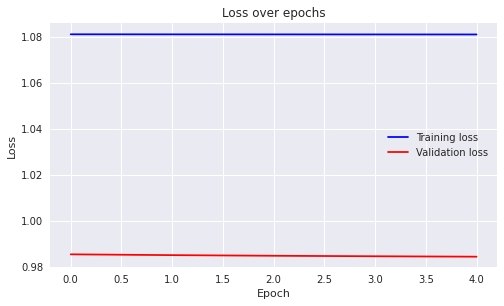

In [86]:
model, optimizer, _ = training_loop(
    model, criterion, optimizer, train_dataloader, valid_dataloader, EPOCHS_COUNT, device
)